# Fourier Transformation 

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [29]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes

In [30]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = True

In [31]:
# Getting the data and converting to numpy array: 

dataframe_m = pd.read_csv('Data/mdata.csv', header=None, index_col=None)
dataframe_p = pd.read_csv('Data/pdata.csv', header=None, index_col=None)

dataframe_m = dataframe_m.to_numpy()
dataframe_p = dataframe_p.to_numpy()

In [32]:
# Identifying and saving the traces, where the concentration gets very small. 

removed_traces_m = []
removed_idx = [] 
removed_traces_p = []

for i in range(0, 422): 
    for j in range(49, 287):  # Ocsillation should begin after the 49th datapoint. 
        if dataframe_m[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            
        if dataframe_p[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            break

In [33]:
# Cleaning the dataframes for traces:  

data_m = np.delete(dataframe_m, removed_idx, 0)
data_p = np.delete(dataframe_p, removed_idx, 0)

In [34]:
# Finding the average fluctuations before oscillations to use as a baseline/initial error for fitting

fluct_m = [(np.std(data_m[i][:49], ddof=1)) for i in range(len(data_m))]  
fluct_p = [(np.std(data_p[i][:49], ddof=1)) for i in range(len(data_p))]

avefluct_m = np.mean(fluct_m)  # Maybe use mode/median instead
avefluct_p = np.mean(fluct_p)

print(f'The mean fluctuations before oscillations: {avefluct_m:.2f}(mdm2) and {avefluct_p:.2f}(p53)')

The mean fluctuations before oscillations: 9.34(mdm2) and 22.37(p53)


In [ ]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

# Fitting all traces with n'th order polynomials: 
time = np.linspace(0, 287/2, 287)
t = time[49:]

resi_m = []
resi_p = []

save_fit = False

for i in range(21):
    
    pn = [] 
    mn = [] 
    
    for j in range(len(data_p)):
        coef_p = np.polyfit(t, data_p[j][49:], i)
        coef_m = np.polyfit(t, data_m[j][49:], i)
    
        pn.append(data_p[j][49:] - np.polyval(coef_p[:], t))
        mn.append(data_m[j][49:] - np.polyval(coef_m[:], t))
        
    resi_p.append(pn)
    resi_m.append(mn)
    
    if save_fit: 
    
        np.savetxt(r'Data/resi_p_n'+str(i)+'.csv', pn, delimiter=',')
        np.savetxt(r'Data/resi_m_n'+str(i)+'.csv', mn, delimiter=',')  

In [11]:
# Rolling the mdm2 traces: 

roll_resi_m = np.zeros(shape=(21, 402, 238))

for i in range(len(resi_m)): 
    for j in range(len(resi_m[i])):
        roll_resi_m[i][j] = np.roll(resi_m[i][j], -3)

In [12]:
# Power spectrum for all traces:

from scipy.fft import fft, rfft, fftfreq

# Lists for different polynomium fit:  Size = (21, 402, 120) 
FT_m = []
FT_p = []

FT_m_norm = []
FT_p_norm = []


for i in range(len(resi_p)):   # Looping through number of polynomial fits
    FT_mn = [] 
    FT_pn = [] 
    
    FT_mn_norm = [] 
    FT_pn_norm = [] 

    
    for j in range(len(resi_p[i])):                   # Looping through all traces 
        FTm = np.square(np.abs(rfft(resi_m[i][j])))
        FTp = np.square(np.abs(rfft(resi_p[i][j])))
    
        FT_mn.append(FTm)
        FT_pn.append(FTp)
    
        FT_mn_norm.append(FTm / max(FTm))
        FT_pn_norm.append(FTp / max(FTp))
        
        
    FT_m.append(FT_mn)
    FT_p.append(FT_pn)
    FT_m_norm.append(FT_mn_norm)
    FT_p_norm.append(FT_pn_norm)

    
sampling_rate = 2  # 2 datapoints per hour 
frequency = np.linspace(0, sampling_rate/2, len(FT_m[0][0]))

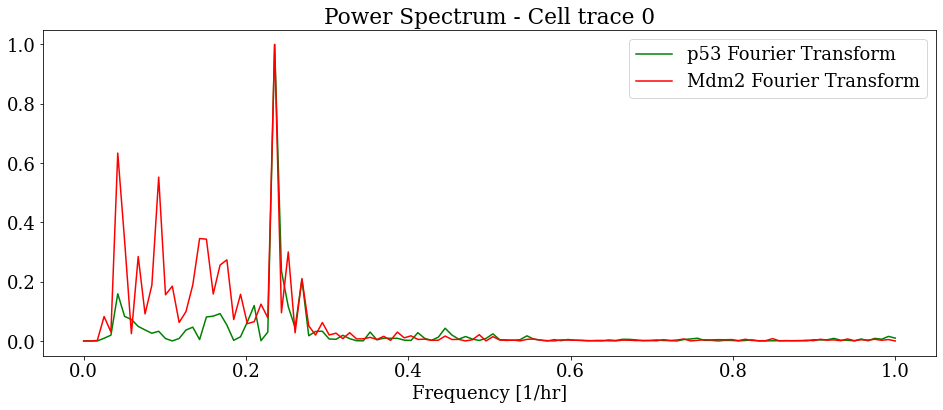

In [13]:
# Example of power spectrum: 

fig, ax = plt.subplots(figsize=(16,6))

ax.plot(frequency, np.array(FT_p_norm[7][0]), color='green', label='p53 Fourier Transform')
ax.plot(frequency, np.array(FT_m_norm[7][0]), color='red', label='Mdm2 Fourier Transform')
ax.set(xlabel='Frequency [1/hr]', 
       title='Power Spectrum - Cell trace 0')
ax.legend();

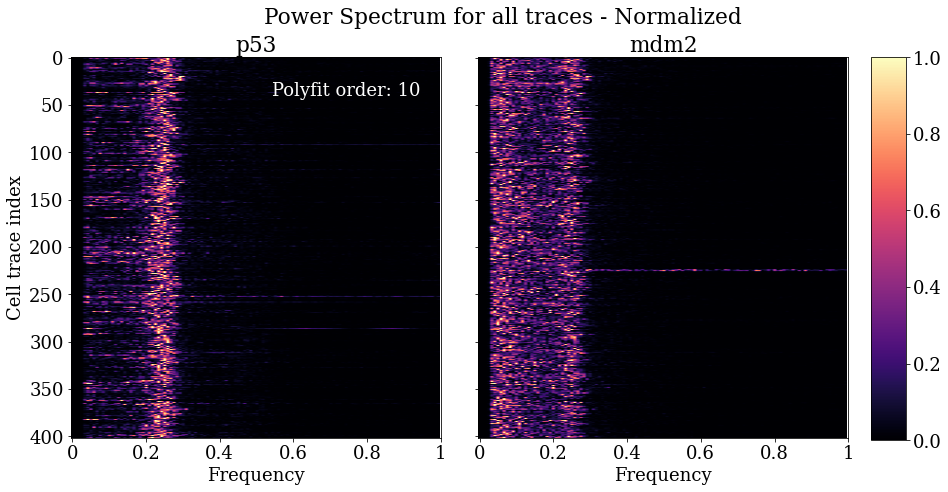

In [14]:
# Plotting the normalized power spectrums as a matrix: 

n_poly = 10 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)
suptitle = fig.suptitle('Power Spectrum for all traces - Normalized', y=0.98)

xticks_pos = np.linspace(0, 120, 6)
xticks_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

im1 = axs[0].imshow(FT_p_norm[n_poly], cmap='magma', aspect='auto', vmin=0, vmax=1)
axs[0].set(xticks=xticks_pos, 
        xlabel='Frequency',
        ylabel='Cell trace index',
        title='p53')

axs[0].text(65, 40, f'Polyfit order: {n_poly}', color='white')

axs[0].set_xticklabels(xticks_labels)

im2 = axs[1].imshow(FT_m_norm[n_poly], cmap='magma', aspect='auto', vmin=0, vmax=1)
axs[1].set(xticks=xticks_pos, 
        xlabel='Frequency', 
        title='mdm2')
axs[1].set_xticklabels(xticks_labels)

fig.subplots_adjust(right=0.8, wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.76])   # left, bottom, width, height
fig.colorbar(im1, cax=cbar_ax);

#fig.tight_layout()

In [15]:
# Averaging along columns for each polynomial fit: 

FT_m_mean = []
FT_p_mean = []

FT_m_norm_mean = []
FT_p_norm_mean = []

for i in range(len(FT_m_norm)):
        FT_m_mean.append(np.mean(FT_m[i], axis=0))
        FT_p_mean.append(np.mean(FT_p[i], axis=0))
        FT_m_norm_mean.append(np.mean(FT_m_norm[i], axis=0))
        FT_p_norm_mean.append(np.mean(FT_p_norm[i], axis=0))

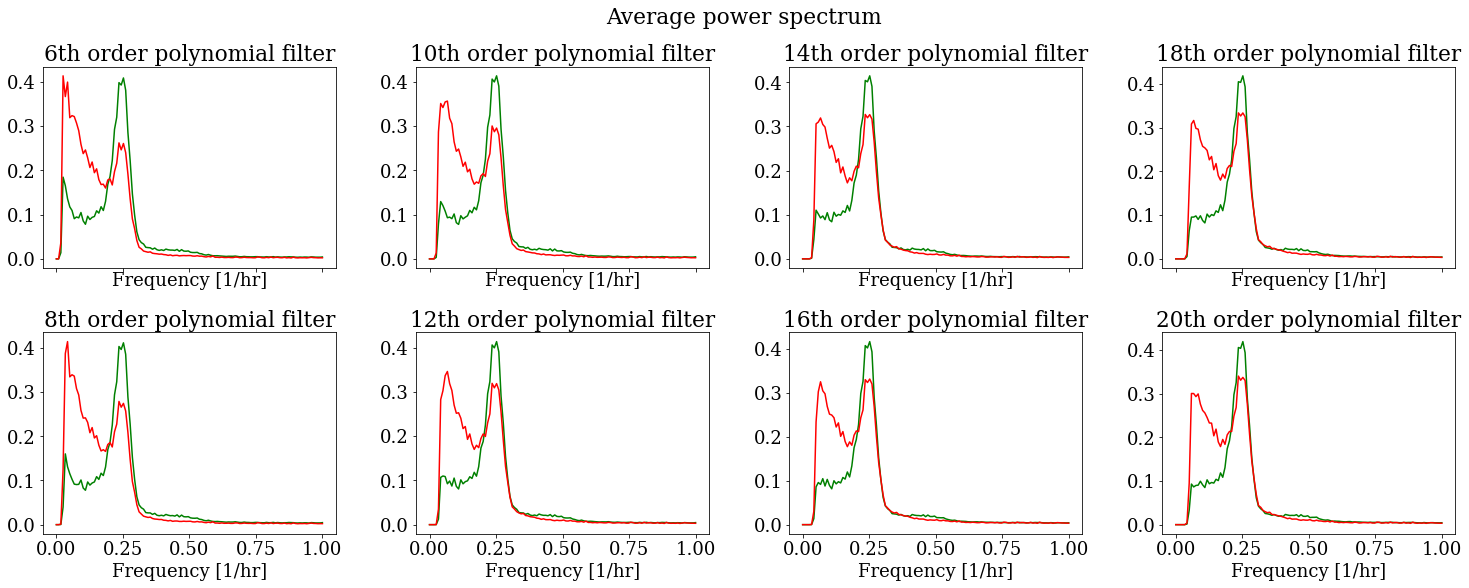

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(21,8), sharex=True)
suptitle = fig.suptitle('Average power spectrum', y=1.03)

for i in range(2): 
    for j in range(4): 
        idx_FT = 2*i + 4*j + 6
        ax[i,j].plot(frequency, FT_p_norm_mean[idx_FT], color='green', label='Normalized p53 Fourier Transform')
        ax[i,j].plot(frequency, FT_m_norm_mean[idx_FT], color='red', label='Normalized mdm2 Fourier Transform')
        ax[i,j].set(xlabel='Frequency [1/hr]', 
               title=f'{idx_FT}th order polynomial filter')
        
fig.tight_layout()

if save_plots: 
    plt.savefig(r'Graphs/PolyxFourier.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

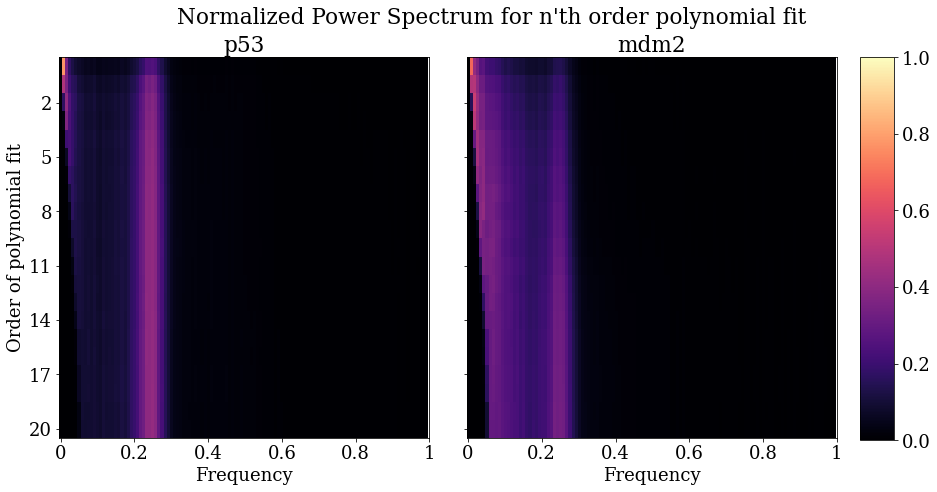

In [27]:
# The average traces as 2d histogram: 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)
suptitle = fig.suptitle("Normalized Power Spectrum for n'th order polynomial fit", y=0.98)

xticks_pos = np.linspace(0, 120, 6)
xticks_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

yticks_pos = np.linspace(2, 20, 7)
yticks_labels = ['2', '5', '8', '11', '14', '17', '20']

im1 = axs[0].imshow(FT_p_norm_mean, cmap='magma', aspect='auto', vmin=0, vmax=1)
axs[0].set(xticks=xticks_pos, 
           yticks=yticks_pos, 
           xlabel='Frequency',
           ylabel='Order of polynomial fit',
           title='p53')

axs[0].set_xticklabels(xticks_labels)
axs[0].set_yticklabels(yticks_labels)

im2 = axs[1].imshow(FT_m_norm_mean, cmap='magma', aspect='auto', vmin=0, vmax=1)
axs[1].set(xticks=xticks_pos,
           yticks=yticks_pos, 
           xlabel='Frequency', 
           title='mdm2')

axs[1].set_xticklabels(xticks_labels)
axs[1].set_yticklabels(yticks_labels)

fig.subplots_adjust(right=0.8, wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.76])   # left, bottom, width, height
fig.colorbar(im1, cax=cbar_ax)

#fig.tight_layout()


if save_plots: 
    plt.savefig(r'Graphs/AvePowerXPoly.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [18]:
correct_freq_p = [] 
correct_freq_m = [] 

for i in range(len(resi_p)): 
    count_p = 0 
    count_m = 0 
    
    for j in range(len(resi_p[i])): 
        
        if 0.1 <= frequency[np.argmax(FT_p[i][j])] <= 0.4: 
            count_p +=1 
            
        if 0.1 <= frequency[np.argmax(FT_m[i][j])] <= 0.4: 
            count_m +=1 
        
    
    correct_freq_p.append(count_p / len(resi_p[i]))
    correct_freq_m.append(count_m / len(resi_m[i]))

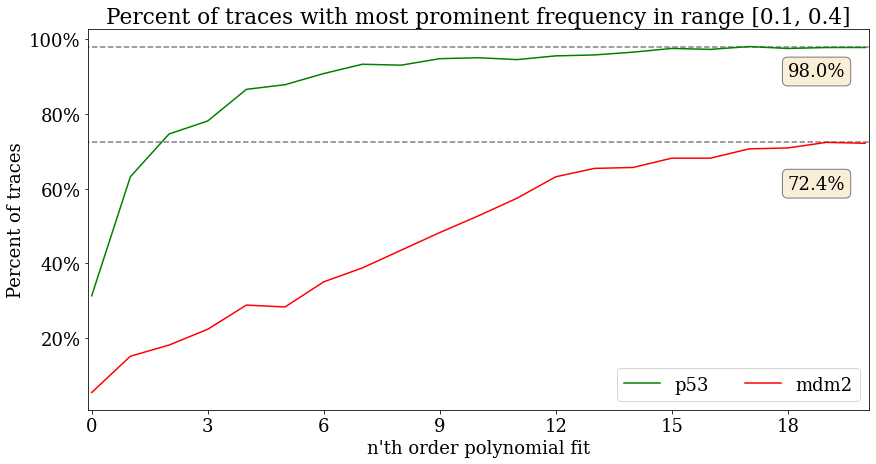

In [21]:
from matplotlib.ticker import MaxNLocator, PercentFormatter

fig, ax = plt.subplots(figsize=(14,7))

naxis = np.linspace(0, 20, 21)
ax.plot(naxis, correct_freq_p, color='green', label='p53')
ax.plot(naxis, correct_freq_m, color='red', label='mdm2')

ax.set(xlim=(-0.1, 20.1), 
       xlabel="n'th order polynomial fit", 
       ylabel='Percent of traces', 
       title='Percent of traces with most prominent frequency in range [0.1, 0.4]')

ax.legend(loc='lower right', ncol=2)

ax.hlines(np.max(correct_freq_p), -0.2, 20.2, linestyle='dashed', color='grey')
ax.hlines(np.max(correct_freq_m), -0.2, 20.2, linestyle='dashed', color='grey')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.text(18, 0.9, f'{np.max(correct_freq_p)*100:2.1f}%', bbox=props)
ax.text(18, 0.6, f'{np.max(correct_freq_m)*100:2.1f}%', bbox=props)

if save_plots: 
    plt.savefig(r'Graphs/PercentCorrectFreq.png');

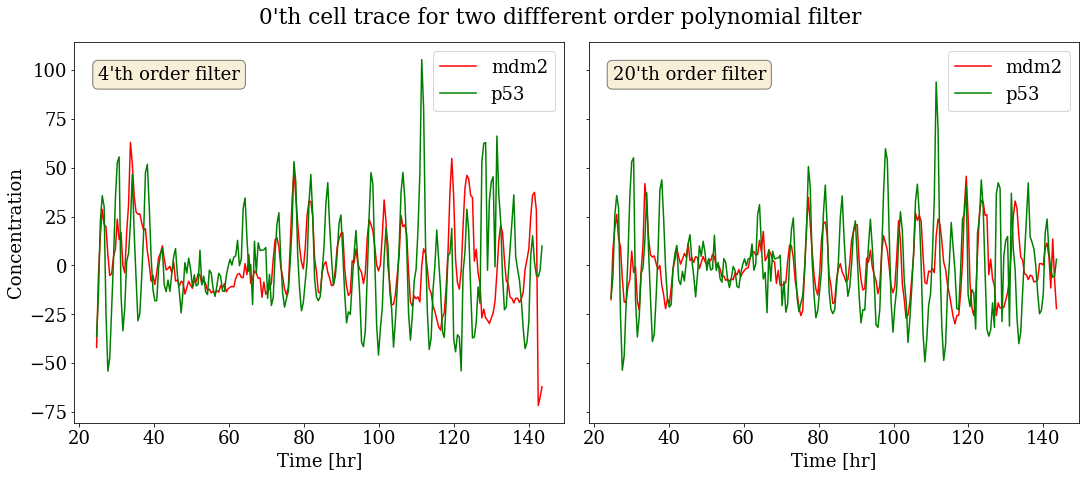

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,7), sharey=True)

suptitle = fig.suptitle("0'th cell trace for two diffferent order polynomial filter", y=0.95)

fig.subplots_adjust(wspace=0.05)

ax[0].plot(t, roll_resi_m[4][0], color='red', label='mdm2')
ax[0].plot(t, resi_p[4][0], color='green', label='p53')

ax[0].set(xlabel='Time [hr]', 
          ylabel='Concentration')
ax[0].legend()

ax[1].plot(t, roll_resi_m[20][0], color='red', label='mdm2')
ax[1].plot(t, resi_p[20][0], color='green', label='p53')

ax[1].set(xlabel='Time [hr]')
ax[1].legend()

ax[0].text(25, 95, "4'th order filter", bbox=props)
ax[1].text(25, 95, "20'th order filter", bbox=props)

if save_plots: 
    plt.savefig(r'Graphs/CheckOfFilter.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);